# Import necessary dependencies

In [1]:
from types import NotImplementedType
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import json
import os
import keras

# For file saving
from datetime import datetime, timedelta, timezone

2025-07-22 04:24:31.388606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753158271.592333      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753158271.653654      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set seed

In [2]:
SEED = 50
keras.utils.set_random_seed(SEED)

# Mount drive and determine data directory


In [3]:
# Mount data from Google Drive
full_data_dir = "/kaggle/input/full-dataset-check/Dataset_Classification_170725"

# Portion to set image size , model paremeter tweaks

In [ ]:
# Set consistent image dimensions
# image_height = 310
# image_width = 660

image_height = 155
image_width = 330

# How many samples the model sees before updating weights and doing backpropagation
batch_size = 32
# How many times the entire dataset is seen by the model
epochs = 300

# Learning rate
learning_rate = 1e-6
# What optimizer to use for model compiling
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Patience for early stopping
patience = 10

# Prep data

In [5]:
# Set the training dataset
training_dataset = keras.utils.image_dataset_from_directory(
    full_data_dir,
    seed=SEED,
    image_size = (image_height, image_width),
    batch_size = None,
    validation_split=0.4,
    subset="training"
)

# Set the validation dataset (later test data will be taken from here)
validation_full_dataset = keras.utils.image_dataset_from_directory(
    full_data_dir,
    seed=SEED,
    image_size = (image_height, image_width),
    batch_size = None,
    validation_split=0.4,
    subset="validation"
)

remaining_data_to_split = tf.data.experimental.cardinality(validation_full_dataset).numpy()

validation_dataset = validation_full_dataset.take(remaining_data_to_split // 2)
test_dataset = validation_full_dataset.skip(remaining_data_to_split // 2)

print(f"Training data count: {tf.data.experimental.cardinality(training_dataset).numpy()}")
print(f"Validation data count: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"Test data count: {tf.data.experimental.cardinality(test_dataset).numpy()}")


Found 3000 files belonging to 3 classes.
Using 1800 files for training.
Found 3000 files belonging to 3 classes.
Using 1200 files for validation.
Training data count: 1800
Validation data count: 600
Test data count: 600


# Get number of classes dynamically before batching

In [6]:
# Dynamically get number of classes and class names
class_names = training_dataset.class_names
num_classes = len(training_dataset.class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Public Bank', 'Rototype', 'Standard Charted']
Number of classes: 3


# Batch and prefetch data

In [7]:
# Batch and Prefetch data to speed up overall training

training_dataset = training_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Functional model

In [8]:
"""
Default template given
"""

# Function for creating a conv block
def conv_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Function to actually fit model

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    for _ in range(3):
        x = conv_block(x, 64)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="ResNet")

# Compile model

In [9]:


# Initialise model and store it into a variable
model_resnet = build_resnet(input_shape=(image_height, image_width, 3), num_classes = num_classes)

# Prepare model for training, set the loss function, optimizer to use, what metrics to monitor
model_resnet.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model, insert converted training data, set the batch size, set the amount of epochs)
# Initialise an EarlyStopping object to dynamically track and avoid over-training
early_stop = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)

model_resnet.summary()

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 155, 330,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 155, 330,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 78, 165,   │      9,472 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 39, 83,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 39, 83,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 39, 83,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 39, 83,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 39, 83,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 39, 83,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 39, 83,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 39, 83,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 39, 83,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 39, 83,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 39, 83,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 39, 83,    │          0 │ activation[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 39, 83,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 39, 83,    │     36,928 │ activation_1[0][

 Total params: 249,987 (976.51 KB)

 Trainable params: 249,219 (973.51 KB)

 Non-trainable params: 768 (3.00 KB)

# Train model

In [10]:
# Model is than stored into a variable for use later in graph plotting
%time history = model_resnet.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stop])

Epoch 1/300


I0000 00:00:1753158297.506661      97 service.cc:148] XLA service 0x79b9f401bf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753158297.507905      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753158298.266987      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/57 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3889 - loss: 1.2866  

I0000 00:00:1753158302.530898      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.3393 - loss: 1.2686 - val_accuracy: 0.3133 - val_loss: 1.1152
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3506 - loss: 1.2672 - val_accuracy: 0.3033 - val_loss: 1.1274
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3615 - loss: 1.2272 - val_accuracy: 0.3133 - val_loss: 1.1371
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3350 - loss: 1.2374 - val_accuracy: 0.3067 - val_loss: 1.1471
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4020 - loss: 1.1648 - val_accuracy: 0.3000 - val_loss: 1.1612
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4007 - loss: 1.1518 - val_accuracy: 0.3083 - val_loss: 1.1451
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3835 - loss: 1.1630 - val_accuracy: 0.2983 - val_loss: 1.1280
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4042 - loss: 1.1629 - val_accuracy: 0.3217 - val

# Save Model

In [11]:
# Dynamically make file path where needed

# Instantiate a time object for determining current timezone
current_zone = timezone(timedelta(hours=8))
timestamp = datetime.now(tz=current_zone).strftime("%d%m%Y_%H%M")

model_name = f"resnet_3000_v2"
model_save_file_path = f"/kaggle/working/saved_models_resnet/{model_name}_{timestamp}/"

# Create the directory if it doesn't exist
os.makedirs(model_save_file_path, exist_ok=True)

# Save model in h5 format
model_resnet.save(f"{model_save_file_path}{model_name}_{timestamp}.h5")

# Test model's accuracy on un-seen data

In [12]:
"""IF NEED TO LOAD MODEL, OTHERWISE PLEASE COMMENT THIS BLOCK OUT"""

# # Load model and other json stuff

# copy_paste = "/content/drive/MyDrive/HT Consulting Bootcamp/saved_models_resnet/resnet_3000_v2_22072025_0340/resnet_3000_v2_22072025_0340"

# # Load model to be evaluated (variable used to train on latest trained model, manually change model name to test specific saved model)
# model_resnet = tf.keras.models.load_model(f"{copy_paste}.h5")

'IF NEED TO LOAD MODEL, OTHERWISE PLEASE COMMENT THIS BLOCK OUT'

In [13]:
print(f"Validation Accuracy Score = {np.max(history.history['val_accuracy']) * 100:.2f}%")

test_loss, test_acc = model_resnet.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")




Validation Accuracy Score = 94.67%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9435 - loss: 0.3742
Test Accuracy: 94.50%
Test Loss: 0.3718


# Include other important info for experiment monitoring

In [14]:
# Save history file to re-create history diagram
with open(f"{model_save_file_path}{model_name}_{timestamp}.json", "w") as f:
  json.dump(history.history, f)


# Create a dictionary with the parameters or metadata you want to save
model_params = {
    "model_name": f"{model_name}_{timestamp}",
    "image_size": [image_height, image_width],
    "batch_size": batch_size,
    "optimizer": optimizer.name,
    "epochs": epochs,
    "patience": patience,
    "learning_rate": learning_rate,
    "test_accuracy" : f"{test_acc * 100:.2f}%"
}

# Save additional parameter info to another json
with open(f"{model_save_file_path}{model_name}_parameters_{timestamp}.json", "w") as f:
    json.dump(model_params, f, indent=4)

# Graphs Section

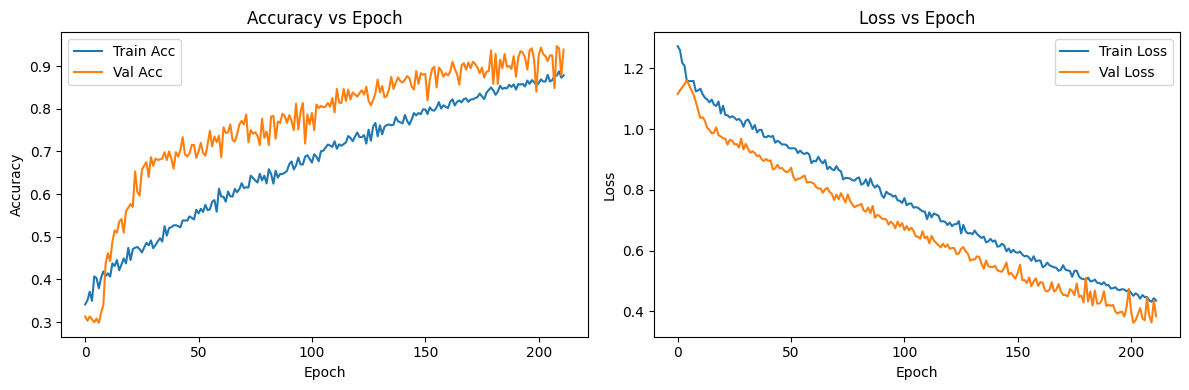

In [15]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


<Figure size 800x800 with 0 Axes>

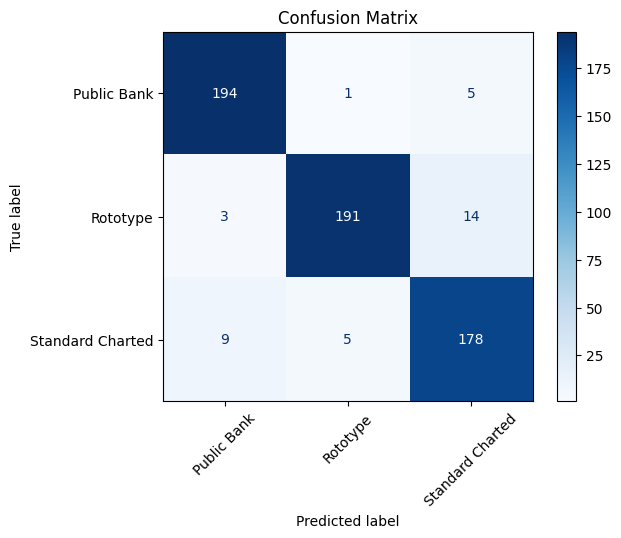

              Class  Accuracy (%)  Precision (%)  Recall (%)  Specificity (%)  \
0       Public Bank         93.83          94.17       97.00            97.00   
1          Rototype         93.83          96.95       91.83            98.47   
2  Standard Charted         93.83          90.36       92.71            95.34   

   F1-Score (%)  
0         95.57  
1         94.32  
2         91.52  


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model_resnet.predict(images)
    pred_labels = tf.argmax(predictions, axis=1).numpy()
    y_pred.extend(pred_labels)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Specificity calculation
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Other metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Tabular format
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy (%)': [accuracy * 100] * len(class_names),
    'Precision (%)': precision * 100,
    'Recall (%)': recall * 100,
    'Specificity (%)': np.array(specificities) * 100,
    'F1-Score (%)': f1 * 100
})

metrics_df = metrics_df.round(2)
print(metrics_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


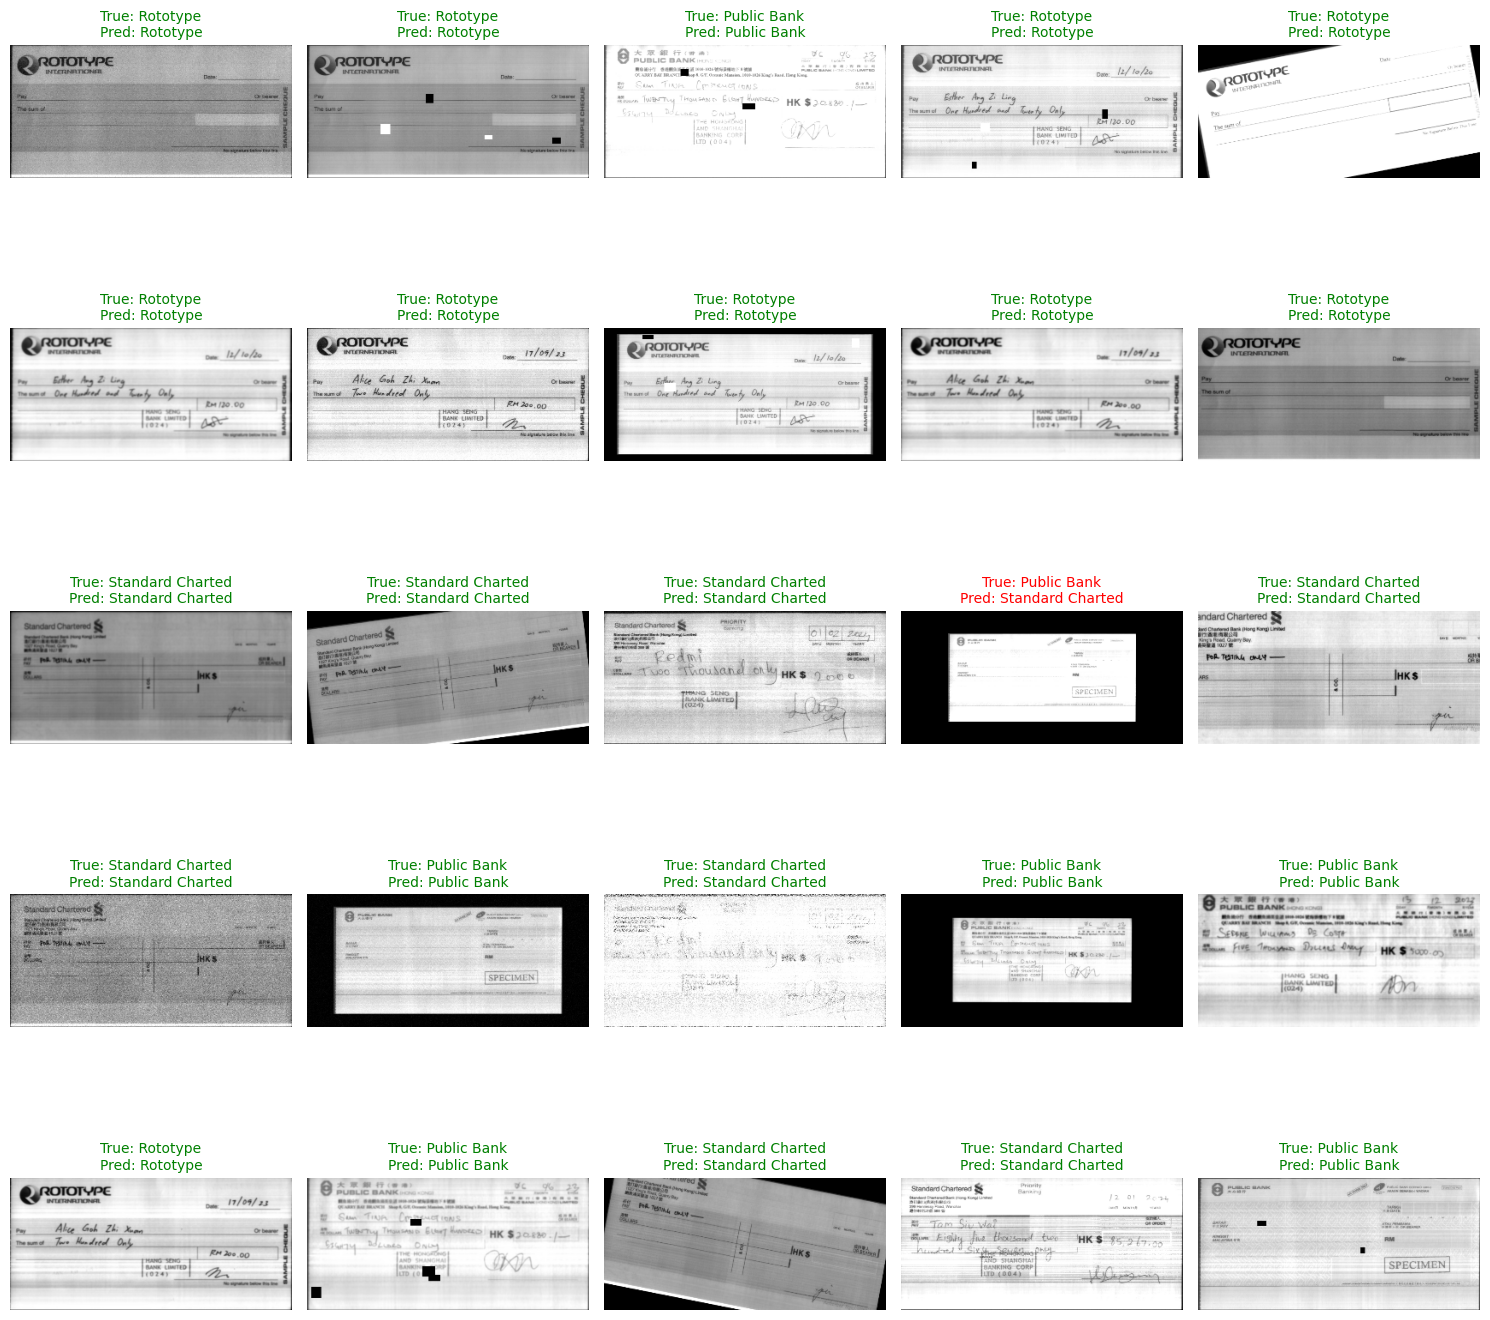

In [17]:


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get one batch from test dataset
for images, labels in test_dataset.take(1):
    predictions = model_resnet.predict(images)
    pred_labels = tf.argmax(predictions, axis=1).numpy()

    num_to_display = min(25, len(images))

    plt.figure(figsize=(15, 15))
    for i in range(num_to_display):
        ax = plt.subplot(5, 5, i + 1)

        # Normalize image to [0,1] for display
        img = images[i].numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        plt.imshow(img)
        true_class = class_names[labels[i].numpy()]
        pred_class = class_names[pred_labels[i]]

        # Color the title: green if correct, red if incorrect
        color = "green" if true_class == pred_class else "red"
        plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10, color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


